In [2]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
! gdown 1aUb9Gk_BtuY3uNcANpQ51cKbZnGkeQhq

Downloading...
From: https://drive.google.com/uc?id=1aUb9Gk_BtuY3uNcANpQ51cKbZnGkeQhq
To: /content/kddcup99_csv.csv
100% 74.9M/74.9M [00:01<00:00, 74.6MB/s]


In [4]:
path_to_file = "kddcup99_csv.csv"
data = pd.read_csv(path_to_file, index_col=False)
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal


In [5]:
# Data Cleaning
print('Null values in dataset are',len(data[data.isnull().any(1)]))
print('='*40)

Null values in dataset are 0


<ipython-input-5-9e7f7d0b047f>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  print('Null values in dataset are',len(data[data.isnull().any(1)]))


In [6]:
# Checkng for DUPLICATE values
data.drop_duplicates(keep='first', inplace = True)
data.dropna(inplace=True,axis=1)
print("Read {} rows.".format(len(data)))

Read 145585 rows.


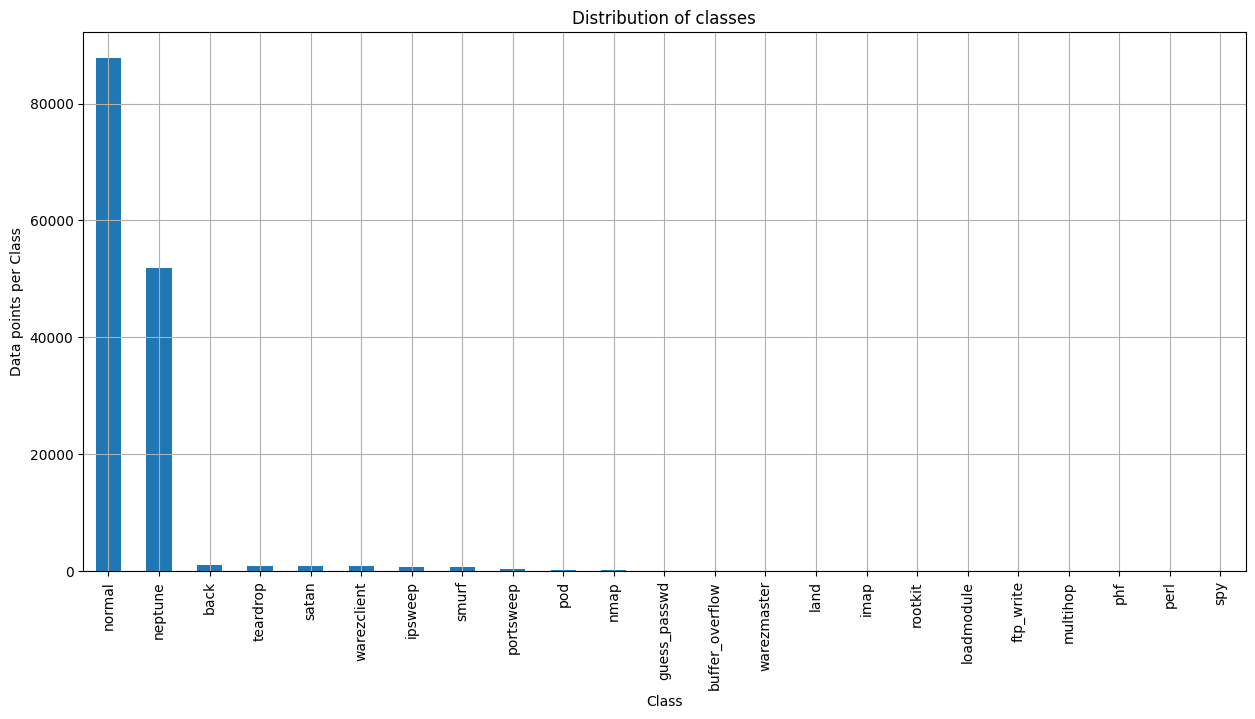

In [7]:
# Exploratory data analysis
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
class_distribution = data['label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of classes')
plt.grid()
plt.show()

In [8]:
from sklearn.manifold import TSNE

In [9]:
data['normality'] = data['label'].apply(lambda x: 'normal' if x == 'normal' else 'not normal')

In [10]:
columns_to_drop = [column for column in data.columns if data[column].dtype == 'object']

In [11]:
extracted_sample, _ = train_test_split(
          data, train_size=.1,
          stratify=data['label']
)

In [12]:
compressed_data = TSNE().fit_transform(extracted_sample.drop(columns_to_drop, axis=1))

In [13]:
tsne_column_names = ['first_component', 'second_component']
tsne_result_df = pd.DataFrame(compressed_data, columns=tsne_column_names)

In [14]:
tsne_result_df['normality'] = extracted_sample['normality'].reset_index(drop=True)

<Axes: xlabel='first_component', ylabel='second_component'>

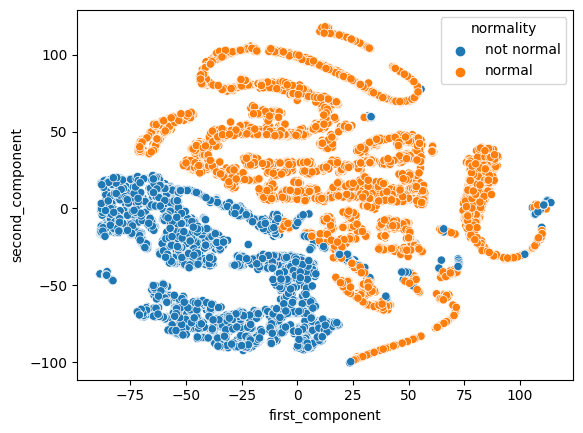

In [15]:
sns.scatterplot(
    tsne_result_df, x=tsne_result_df['first_component'], y=tsne_result_df['second_component'],
    hue='normality'
)

In [16]:
data['label'].unique()

array(['normal', 'buffer_overflow', 'loadmodule', 'perl', 'neptune',
       'smurf', 'guess_passwd', 'pod', 'teardrop', 'portsweep', 'ipsweep',
       'land', 'ftp_write', 'back', 'imap', 'satan', 'phf', 'nmap',
       'multihop', 'warezmaster', 'warezclient', 'spy', 'rootkit'],
      dtype=object)

In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

numeric_columns = data.select_dtypes(include=['int64', 'float64'])
scaler = StandardScaler()

scaled_data = scaler.fit_transform(numeric_columns)
preprocesed_df = pd.DataFrame(scaled_data, columns=numeric_columns.columns)

encoder = LabelEncoder()

preprocesed_df['protocol_type'] = encoder.fit_transform(data['protocol_type'])
preprocesed_df['service'] = encoder.fit_transform(data['service'])
preprocesed_df['flag'] = encoder.fit_transform(data['flag'])
preprocesed_df['label_encoded'] = encoder.fit_transform(data['label'])

preprocesed_df['label'] = data['label'].reset_index(drop=True)
preprocesed_df['IsBenign'] = (preprocesed_df['label'] == 'normal').astype(int)

#Classification that traffic is benign

In [18]:
binary_classification_df = preprocesed_df.drop(['label', 'label_encoded'], axis=1)

In [19]:
train_df, test_df = train_test_split(binary_classification_df, test_size=.3, stratify=binary_classification_df['IsBenign'])

In [20]:
train_features = train_df.drop('IsBenign', axis=1)
train_labels = train_df['IsBenign']
test_features = test_df.drop('IsBenign', axis=1)
test_labels = test_df['IsBenign']

##Light GB model

In [21]:
model = lgb.LGBMClassifier()

In [22]:
start = time.time()
model.fit(train_features, train_labels)
stop = time.time()
print(f"Training time: {stop - start}s")

[LightGBM] [Info] Number of positive: 61481, number of negative: 40428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2922
[LightGBM] [Info] Number of data points in the train set: 101909, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603293 -> initscore=0.419206
[LightGBM] [Info] Start training from score 0.419206
Training time: 1.9066739082336426s


In [23]:
predicted_lgb = model.predict(test_features)
accuracy_score(test_labels, predicted_lgb)

0.9995420826082975

In [24]:
print(classification_report(test_labels, predicted_lgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17326
           1       1.00      1.00      1.00     26350

    accuracy                           1.00     43676
   macro avg       1.00      1.00      1.00     43676
weighted avg       1.00      1.00      1.00     43676



<Figure size 2000x1000 with 0 Axes>

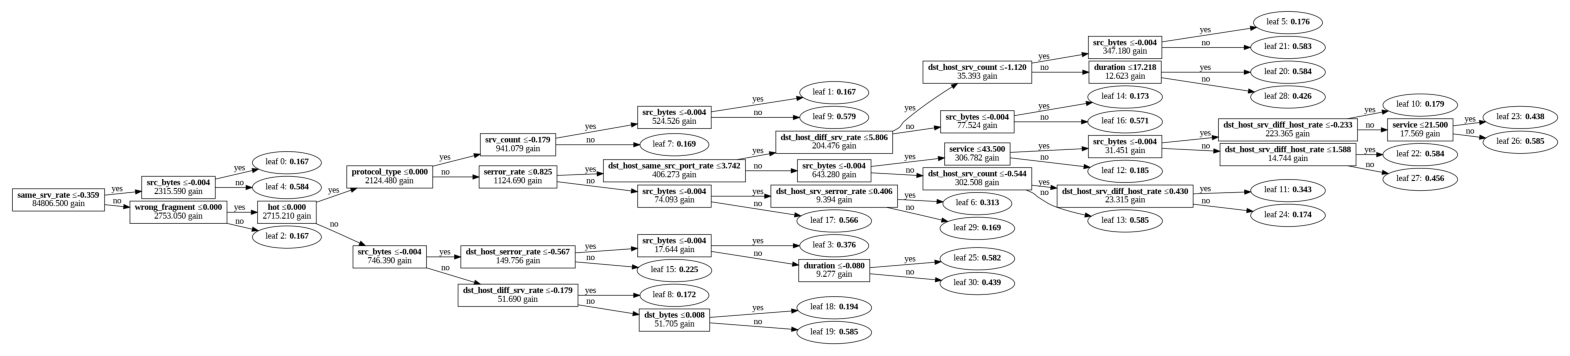

In [25]:
tree_index = 0
plt.figure(figsize=(20, 10))
lgb.plot_tree(model, tree_index=tree_index, figsize=(20, 10), show_info=['split_gain'])
plt.show()

##SVM with grid search

In [26]:
hyperparameter = {'alpha':[0.01, 0.1, 1], 'penalty':['l1', 'l2']}
svm = SGDClassifier(loss='hinge')
svm_grid = GridSearchCV(svm, param_grid=hyperparameter, cv=5, verbose=1, n_jobs=-1)

In [27]:
start = time.time()
svm_grid.fit(train_features, train_labels)
stop = time.time()
print(f"Training time: {stop - start}s")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training time: 24.731475591659546s


In [28]:
def print_grid_search_attributes(model):
  print('| Best Estimator |')
  print('\n\t{}\n'.format(model.best_estimator_))
  print('| Best parameters |')
  print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))
  print('| No of CrossValidation sets |')
  print('\n\tTotal numbre of cross validation sets: {}\n'.format(model.n_splits_))
  print('| Best Score |')
  print('\n\tAverage Cross Validate scores of best estimator :\t{}\n'.format(model.best_score_))

In [29]:
print_grid_search_attributes(svm_grid)

| Best Estimator |

	SGDClassifier(alpha=0.01)

| Best parameters |
	Parameters of best estimator : 

	{'alpha': 0.01, 'penalty': 'l2'}

| No of CrossValidation sets |

	Total numbre of cross validation sets: 5

| Best Score |

	Average Cross Validate scores of best estimator :	0.9815521560855824



In [30]:
predicted_svm = svm_grid.predict(test_features)
print(classification_report(test_labels, predicted_svm))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     17326
           1       0.98      1.00      0.99     26350

    accuracy                           0.98     43676
   macro avg       0.99      0.98      0.98     43676
weighted avg       0.98      0.98      0.98     43676



# Sequential model

In [31]:
from keras.models import Sequential
from keras.layers import Dense

seq_model = Sequential()

seq_model.add(Dense(40,input_dim =41,activation = 'relu',kernel_initializer='random_uniform'))
seq_model.add(Dense(10,activation='sigmoid',kernel_initializer='random_uniform'))
seq_model.add(Dense(2,activation='softmax'))

seq_model.compile(loss ='sparse_categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [32]:
start = time.time()
seq_model.fit(train_features, train_labels, epochs=10,batch_size=64)
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/10
1593/1593 [==============================] - 4s 2ms/step - loss: 0.0692 - accuracy: 0.9818
Epoch 2/10
1593/1593 [==============================] - 4s 2ms/step - loss: 0.0175 - accuracy: 0.9953
Epoch 3/10
1593/1593 [==============================] - 4s 3ms/step - loss: 0.0144 - accuracy: 0.9959
Epoch 4/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.0126 - accuracy: 0.9965
Epoch 5/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.0115 - accuracy: 0.9968
Epoch 6/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.0107 - accuracy: 0.9969
Epoch 7/10
1593/1593 [==============================] - 4s 3ms/step - loss: 0.0105 - accuracy: 0.9970
Epoch 8/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.0097 - accuracy: 0.9972
Epoch 9/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.0091 - accuracy: 0.9975
Epoch 10/10
1593/1593 [==============================] - 3s 2ms/step - loss: 0.008

In [33]:
predicted_seq = seq_model.predict(test_features)

1365/1365 [==============================] - 2s 1ms/step


In [34]:
def get_classification_metric(testy, probs):
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(testy, probs[:,1])
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    return fscore[ix]

get_classification_metric(test_labels, predicted_seq)


0.9982927384475302

#Classification of type of viruses

In [35]:
multi_classification_df = preprocesed_df.drop(['label', 'IsBenign'], axis=1)

In [36]:
train_df, test_df = train_test_split(multi_classification_df, test_size=.3, stratify=multi_classification_df['label_encoded'])

In [37]:
ml_train_features = train_df.drop('label_encoded', axis=1)
ml_train_labels = train_df['label_encoded']
ml_test_features = test_df.drop('label_encoded', axis=1)
ml_test_labels = test_df['label_encoded']

Ligbm for multiclassification

In [38]:
LGBM_ml = lgb.LGBMClassifier()

In [39]:
start = time.time()
LGBM_ml.fit(ml_train_features, ml_train_labels)
stop = time.time()
print(f"Training time: {stop - start}s")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2917
[LightGBM] [Info] Number of data points in the train set: 101909, number of used features: 36
[LightGBM] [Info] Start training from score -5.012688
[LightGBM] [Info] Start training from score -8.487313
[LightGBM] [Info] Start training from score -9.740076
[LightGBM] [Info] Start training from score -7.920918
[LightGBM] [Info] Start training from score -9.452394
[LightGBM] [Info] Start training from score -5.409343
[LightGBM] [Info] Start training from score -8.966886
[LightGBM] [Info] Start training from score -9.740076
[LightGBM] [Info] Start training from score -9.922398
[LightGBM] [Info] Start training from score -1.032979
[LightGBM] [Info] Start training from score -6.822305
[LightGBM] [Info] Start training from score -0.50535

In [40]:
predicted_lgb_ML = LGBM_ml.predict(ml_test_features)
print(accuracy_score(predicted_lgb_ML, ml_test_labels))

0.5716869676710321


In [41]:
#SVM for multiclass

In [42]:
hyperparameter = {'alpha':[0.01, 0.1, 1], 'penalty':['l1', 'l2']}
svm_ml = SGDClassifier(loss='hinge')
svm_grid_ml = GridSearchCV(svm, param_grid=hyperparameter, cv=5, verbose=1, n_jobs=-1)

In [43]:
start = time.time()
svm_grid_ml.fit(ml_train_features, ml_train_labels)
stop = time.time()
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Training time: 557.8212721347809s


In [44]:
predicted_svm_ML = svm_grid_ml.predict(ml_test_features)
print(accuracy_score(predicted_svm_ML, ml_test_labels))

0.9818206795494093


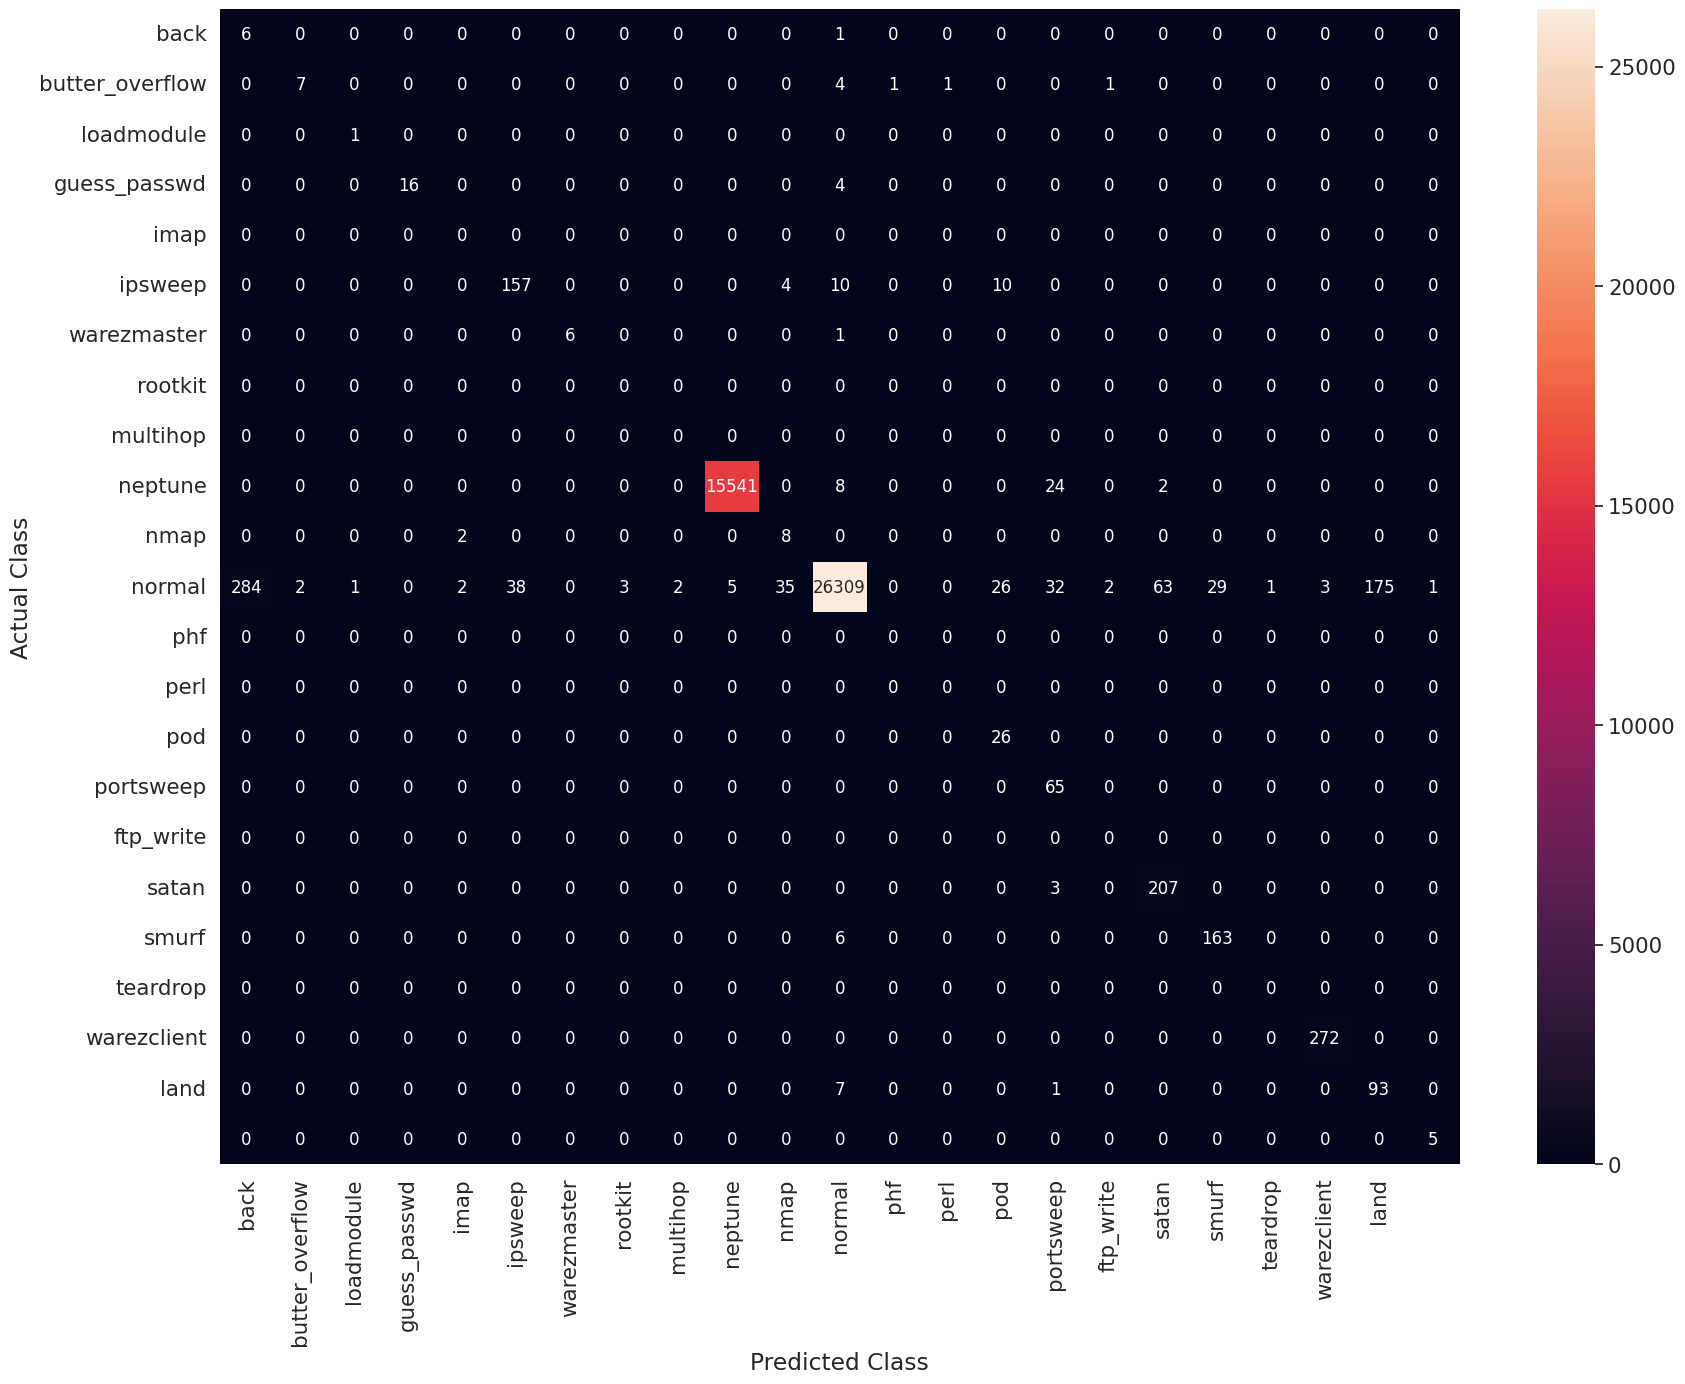

In [45]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confusion_matrix_func(y_test, y_test_pred):
    C = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(C)
    labels = ['back', 'butter_overflow', 'loadmodule', 'guess_passwd', 'imap', 'ipsweep', 'warezmaster', 'rootkit',
'multihop', 'neptune', 'nmap', 'normal', 'phf', 'perl', 'pod', 'portsweep', 'ftp_write', 'satan', 'smurf', 'teardrop', 'warezclient', 'land']
    plt.figure(figsize=(20,15))
    sns.set(font_scale=1.4)
    sns.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')

    plt.show()
confusion_matrix_func(predicted_svm_ML, ml_test_labels)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping
x_columns = ml_train_features.columns
x = ml_train_features.values
dummies = pd.get_dummies(ml_train_labels) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
seq_model_ml = Sequential()
seq_model_ml.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
seq_model_ml.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
seq_model_ml.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
seq_model_ml.add(Dense(1, kernel_initializer='normal'))
seq_model_ml.add(Dense(num_classes,activation='softmax'))
seq_model_ml.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')



# Feature tuning

External feature generating

In [47]:
from scipy.sparse import hstack
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(ml_train_features)
pca_train = pca.transform(ml_train_features)
pca_test = pca.transform(ml_test_features)

print(pca_train.shape)
print(pca_test.shape)



(101909, 5)
(43676, 5)


In [48]:
# src_bytes + dst_bytes
feature_src_dst_train = ml_train_features["src_bytes"] + ml_train_features["dst_bytes"]
feature_src_dst_test = ml_test_features["src_bytes"] + ml_test_features["dst_bytes"]

# same_srv_rate + diff_srv_rate :-
feature_same_srv_train = ml_train_features["same_srv_rate"] + ml_train_features["diff_srv_rate"]
feature_same_srv_test = ml_test_features["same_srv_rate"] + ml_test_features["diff_srv_rate"]

# dst_host_same_srv_rate + dst_host_diff_srv_rate :-
feature_dst_host_train = ml_train_features["dst_host_same_srv_rate"] + ml_train_features["dst_host_diff_srv_rate"]
feature_dst_host_test = ml_test_features["dst_host_same_srv_rate"] + ml_test_features["dst_host_diff_srv_rate"]


In [49]:
ext_train_features = ml_train_features
ext_test_features = ml_test_features

ext_train_features['src_dst'], ext_test_features['src_dst'] = feature_src_dst_train, feature_src_dst_test
ext_train_features['same_srv_diff'], ext_test_features['same_srv_diff'] = feature_same_srv_train, feature_same_srv_test
ext_train_features['dst_host_same_diff'], ext_test_features['dst_host_same_diff'] = feature_dst_host_train, feature_dst_host_test

pca_columns = [f'PC_{i+1}' for i in range(pca_train.shape[1])]

ext_train_features[pca_columns] = pca_train
ext_test_features[pca_columns] = pca_test
ext_train_features

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,...,service,flag,src_dst,same_srv_diff,dst_host_same_diff,PC_1,PC_2,PC_3,PC_4,PC_5
99208,-0.107851,-0.004392,-0.047028,-0.011722,-0.084394,-0.004737,-0.07021,-0.018022,-0.983115,-0.007905,...,45,5,-0.051421,-1.215567,-1.178206,13.397302,0.467827,-2.464480,0.009622,0.229917
36145,-0.107851,0.025568,0.089693,-0.011722,-0.084394,-0.004737,1.33153,-0.018022,1.017175,0.294084,...,22,9,0.115261,0.434717,0.561708,-10.521688,-1.122311,0.170675,0.086024,0.380871
24573,-0.107851,-0.004280,0.012945,-0.011722,-0.084394,-0.004737,-0.07021,-0.018022,1.017175,-0.007905,...,22,9,0.008666,0.434717,0.561708,-10.622266,-1.387273,0.835888,-0.177684,0.815975
6820,-0.107851,-0.003617,-0.041519,-0.011722,-0.084394,-0.004737,-0.07021,-0.018022,1.017175,-0.007905,...,50,9,-0.045137,0.434717,0.281290,17.059510,-4.938023,3.063488,-0.360354,1.116936
39944,-0.107851,-0.004392,-0.047028,-0.011722,-0.084394,-0.004737,-0.07021,-0.018022,-0.983115,-0.007905,...,22,1,-0.051421,0.434717,0.561708,-9.597564,8.577884,3.297079,-0.064168,0.831438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33078,-0.107851,-0.004230,0.075320,-0.011722,-0.084394,-0.004737,-0.07021,-0.018022,1.017175,-0.007905,...,22,9,0.071090,0.434717,0.561708,-10.621939,-1.323834,0.747694,-0.158272,0.746977
142034,-0.107851,-0.004207,0.039520,-0.011722,-0.084394,-0.004737,-0.07021,-0.018022,1.017175,-0.007905,...,22,9,0.035313,0.434717,0.561708,-10.597651,-1.236602,0.485008,-0.134340,0.645060
9411,-0.107851,-0.004274,-0.036208,-0.011722,-0.084394,-0.004737,-0.07021,-0.018022,1.017175,-0.007905,...,22,9,-0.040481,0.434717,0.561708,-10.566264,-1.280322,0.373573,-0.135614,0.661859
30611,-0.107851,-0.004237,0.030837,-0.011722,-0.084394,-0.004737,-0.07021,-0.018022,1.017175,-0.007905,...,22,9,0.026600,0.434717,0.561708,-10.546951,-1.116238,0.377233,-0.087669,0.330132


# Feature avaluating

[LightGBM] [Info] Number of positive: 101231, number of negative: 678
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4896
[LightGBM] [Info] Number of data points in the train set: 101909, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.993347 -> initscore=5.006013
[LightGBM] [Info] Start training from score 5.006013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

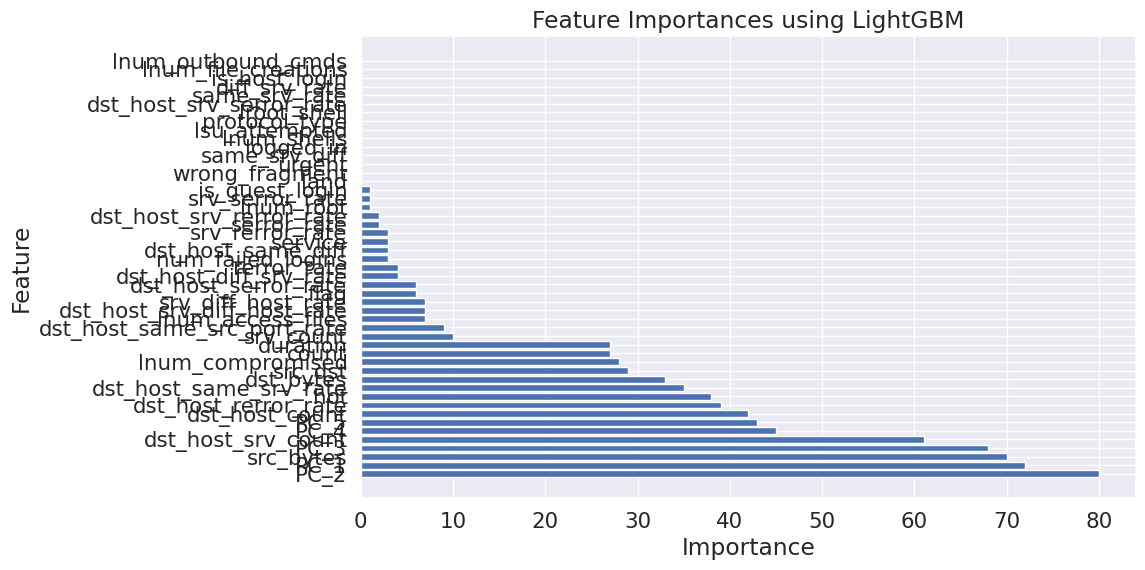

In [50]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

train_data = lgb.Dataset(ext_train_features, label=ml_train_labels)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

num_round = 30  # Кількість ітерацій
bst = lgb.train(params, train_data, num_round)
feature_importances = bst.feature_importance(importance_type='split')
feature_importance_df = pd.DataFrame({'feature': ext_train_features.columns, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances using LightGBM')
plt.show()


In [51]:
feature_nonimportant = feature_importance_df[feature_importance_df['importance'] < 10]['feature'].values
print(feature_nonimportant)

imporatnt_feature_train = ext_train_features.drop(columns=feature_nonimportant)
imporatnt_feature_test = ext_test_features.drop(columns=feature_nonimportant)
imporatnt_feature_train

['dst_host_same_src_port_rate' 'lnum_access_files'
 'dst_host_srv_diff_host_rate' 'srv_diff_host_rate' 'flag'
 'dst_host_serror_rate' 'dst_host_diff_srv_rate' 'rerror_rate'
 'num_failed_logins' 'dst_host_same_diff' 'service' 'srv_rerror_rate'
 'serror_rate' 'dst_host_srv_rerror_rate' 'lnum_root' 'srv_serror_rate'
 'is_guest_login' 'land' 'wrong_fragment' 'urgent' 'same_srv_diff'
 'logged_in' 'lnum_shells' 'lsu_attempted' 'protocol_type' 'lroot_shell'
 'dst_host_srv_serror_rate' 'same_srv_rate' 'diff_srv_rate'
 'is_host_login' 'lnum_file_creations' 'lnum_outbound_cmds']


,duration,src_bytes,dst_bytes,hot,lnum_compromised,count,srv_count,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_rerror_rate,src_dst,PC_1,PC_2,PC_3,PC_4,PC_5
99208,-0.107851,-0.004392,-0.047028,-0.07021,-0.007905,0.703776,-0.228119,0.742006,-1.089102,-1.168755,-0.360879,-0.051421,13.397302,0.467827,-2.464480,0.009622,0.229917
36145,-0.107851,0.025568,0.089693,1.33153,0.294084,-0.661639,-0.163049,0.742006,1.090225,0.979265,-0.164862,0.115261,-10.521688,-1.122311,0.170675,0.086024,0.380871
24573,-0.107851,-0.004280,0.012945,-0.07021,-0.007905,-0.711472,-0.260654,-1.578951,1.090225,0.979265,-0.360879,0.008666,-10.622266,-1.387273,0.835888,-0.177684,0.815975
6820,-0.107851,-0.003617,-0.041519,-0.07021,-0.007905,-0.731405,-0.390794,0.227359,0.305667,0.562812,-0.360879,-0.045137,17.059510,-4.938023,3.063488,-0.360354,1.116936
39944,-0.107851,-0.004392,-0.047028,-0.07021,-0.007905,-0.731405,-0.390794,-1.780774,1.090225,0.979265,2.906061,-0.051421,-9.597564,8.577884,3.297079,-0.064168,0.831438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33078,-0.107851,-0.004230,0.075320,-0.07021,-0.007905,-0.731405,-0.130514,-1.488131,1.090225,0.979265,-0.360879,0.071090,-10.621939,-1.323834,0.747694,-0.158272,0.746977
142034,-0.107851,-0.004207,0.039520,-0.07021,-0.007905,-0.552008,0.194836,-1.185398,1.090225,0.979265,-0.360879,0.035313,-10.597651,-1.236602,0.485008,-0.134340,0.645060
9411,-0.107851,-0.004274,-0.036208,-0.07021,-0.007905,-0.691539,-0.260654,-0.670751,1.090225,0.979265,-0.360879,-0.040481,-10.566264,-1.280322,0.373573,-0.135614,0.661859
30611,-0.107851,-0.004237,0.030837,-0.07021,-0.007905,-0.591874,0.650326,-1.518405,-0.313261,0.979265,-0.360879,0.026600,-10.546951,-1.116238,0.377233,-0.087669,0.330132


In [52]:
# Convert to numpy - Classification
from tensorflow.keras.callbacks import EarlyStopping
x_columns = imporatnt_feature_train.columns
x = imporatnt_feature_train.values
dummies = pd.get_dummies(ml_train_labels) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')


In [53]:
start = time.time()
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=19)
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/19
2389/2389 - 6s - loss: 0.6629 - val_loss: 0.3387 - 6s/epoch - 2ms/step
Epoch 2/19
2389/2389 - 7s - loss: 0.2959 - val_loss: 0.2387 - 7s/epoch - 3ms/step
Epoch 3/19
2389/2389 - 5s - loss: 0.2332 - val_loss: 0.1922 - 5s/epoch - 2ms/step
Epoch 4/19
2389/2389 - 5s - loss: 0.2012 - val_loss: 0.1718 - 5s/epoch - 2ms/step
Epoch 5/19
2389/2389 - 6s - loss: 0.1875 - val_loss: 0.1641 - 6s/epoch - 3ms/step
Epoch 6/19
2389/2389 - 5s - loss: 0.1769 - val_loss: 0.1557 - 5s/epoch - 2ms/step
Epoch 7/19
2389/2389 - 5s - loss: 0.1711 - val_loss: 0.1560 - 5s/epoch - 2ms/step
Epoch 8/19
2389/2389 - 6s - loss: 0.1647 - val_loss: 0.1492 - 6s/epoch - 3ms/step
Epoch 9/19
2389/2389 - 5s - loss: 0.1575 - val_loss: 0.1407 - 5s/epoch - 2ms/step
Epoch 10/19
2389/2389 - 6s - loss: 0.1544 - val_loss: 0.1369 - 6s/epoch - 2ms/step
Epoch 11/19
2389/2389 - 6s - loss: 0.1502 - val_loss: 0.1339 - 6s/epoch - 2ms/step
Epoch 12/19
2389/2389 - 5s - loss: 0.1454 - val_loss: 0.1310 - 5s/epoch - 2ms/step
Epoch 13/19
2

In [54]:
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr))
print('='*50)
model.summary()

Learning Rate - 
0.001
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                180       
                                                                 
 dense_9 (Dense)             (None, 50)                550       
                                                                 
 dense_10 (Dense)            (None, 10)                510       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
 dense_12 (Dense)            (None, 23)                46        
                                                                 
Total params: 1297 (5.07 KB)
Trainable params: 1297 (5.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

In [55]:
print('Train data')
print(x_train.shape)
print(y_train.shape)
print('='*20)
print('Test data')
print(x_test.shape)
print(y_test.shape)
print('='*20)

# Measure accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
print('Predicting on the test data:')
escore = model.evaluate(x_test, y_test, batch_size=32)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)

print(classification_report(encoder.inverse_transform(y_eval), encoder.inverse_transform(pred)))

Train data
(76431, 17)
(76431, 23)
Test data
(25478, 17)
(25478, 23)
Predicting on the test data:
797/797 [==============================] - 1s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

           back       1.00      0.97      0.99       175
buffer_overflow       0.00      0.00      0.00         6
      ftp_write       0.00      0.00      0.00         1
   guess_passwd       0.00      0.00      0.00         8
           imap       0.00      0.00      0.00         1
        ipsweep       0.00      0.00      0.00       115
           land       0.00      0.00      0.00         3
     loadmodule       0.00      0.00      0.00         1
       multihop       0.00      0.00      0.00         1
        neptune       0.97      1.00      0.99      9082
           nmap       0.00      0.00      0.00        20
         normal       1.00      0.99      1.00     15375
           perl       0.00      0.00      0.00         1
            pod       0.00      0.00      0.00        39
      portsweep       0.00      0.00      0.00        75
        rootkit       0.00      0.00      0.00         1
          satan       0.08    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
hyperparameter = {'alpha':[0.01, 0.1, 1], 'penalty':['l1', 'l2']}
svm_ml_2 = SGDClassifier(loss='hinge')
svm_grid_ml_2 = GridSearchCV(svm_ml_2, param_grid=hyperparameter, cv=5, verbose=1, n_jobs=-1)

In [57]:
start = time.time()
svm_grid_ml_2.fit(imporatnt_feature_train, ml_train_labels)
stop = time.time()
print(f"Training time: {stop - start}s")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training time: 63.94603633880615s


In [59]:
imporatnt_feature_test

,duration,src_bytes,dst_bytes,hot,lnum_compromised,count,srv_count,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_rerror_rate,src_dst,PC_1,PC_2,PC_3,PC_4,PC_5
31872,-0.107851,-0.004213,-0.042588,-0.07021,-0.007905,-0.631740,-0.065444,0.742006,0.976900,0.869672,-0.360879,-0.046801,-10.504746,-1.189557,0.041764,-0.104375,0.466328
140631,-0.107851,-0.004279,-0.015323,-0.07021,-0.007905,-0.571941,0.292441,0.742006,1.090225,0.979265,-0.360879,-0.019602,-10.522865,-1.233217,0.095507,-0.128090,0.589760
35718,-0.107034,-0.003485,-0.041585,-0.07021,-0.007905,-0.731405,-0.358259,-0.943211,0.166190,-0.533117,-0.360879,-0.045071,17.053299,-5.085389,3.650163,-0.423476,1.260645
29168,-0.107851,-0.004220,-0.015553,-0.07021,-0.007905,-0.621773,-0.032909,-1.710136,1.090225,0.979265,-0.360879,-0.019774,-10.608570,-1.305992,0.591060,-0.135053,0.599497
80008,-0.107851,-0.004271,0.117468,-0.07021,-0.007905,-0.691539,-0.260654,-1.589042,1.090225,0.979265,-0.360879,0.113197,-10.619758,-1.501381,0.874659,5.015658,1.618595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131677,-0.107851,-0.004392,-0.047028,-0.07021,-0.007905,0.295148,-0.293189,0.742006,-1.097819,-1.168755,2.906061,-0.051421,13.564405,6.496919,3.736710,-0.086065,0.313079
4483,-0.107851,-0.004268,-0.003483,-0.07021,-0.007905,-0.502175,0.357511,0.742006,1.090225,0.979265,-0.360879,-0.007750,-10.518360,-1.191856,0.016169,-0.114275,0.531732
75065,-0.107851,-0.004392,-0.047028,-0.07021,-0.007905,0.574211,-0.065444,0.742006,-1.036798,-1.124918,-0.360879,-0.051421,13.384660,0.430661,-2.407946,0.013827,0.153074
13352,-0.107851,-0.004250,-0.041470,0.63066,-0.007905,-0.671606,-0.032909,-1.457858,1.090225,0.979265,-0.360879,-0.045720,-10.623647,-1.380977,0.788325,-0.161389,0.722231


In [61]:
predicted_svm_ML = svm_grid_ml_2.predict(imporatnt_feature_test)
print(accuracy_score(predicted_svm_ML, ml_test_labels))

0.9640305888817657
